## 1. Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import torch
from scipy.sparse import load_npz, csr_matrix, lil_matrix, save_npz
from scipy import stats
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Check for GPU availability
device = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)
print(f"✓ Libraries imported successfully!")
print(f"✓ Device: {device}")
print(f"✓ PyTorch version: {torch.__version__}")

✓ Libraries imported successfully!
✓ Device: mps
✓ PyTorch version: 2.2.2


## 2. Load Pre-computed Features

This section loads all features that were computed in the feature engineering phase:
- User-item interaction matrix
- Bundle-game mapping matrix
- Game similarity matrices (bundle-based, co-purchase, combined)
- Bundle similarity matrix
- ID mappings (user, item, bundle)
- Game popularity scores

In [2]:
print("=" * 70)
print("LOADING PRE-COMPUTED FEATURES")
print("=" * 70)

features_dir = './features'

# Load sparse matrices
user_item_matrix = load_npz(f'{features_dir}/user_item_matrix.npz')
bundle_game_matrix = load_npz(f'{features_dir}/bundle_game_matrix.npz')
game_similarity_bundle = load_npz(f'{features_dir}/game_similarity_bundle.npz')
game_similarity_copurchase = load_npz(f'{features_dir}/game_similarity_copurchase.npz')
game_similarity_combined = load_npz(f'{features_dir}/game_similarity_combined.npz')
bundle_similarity_matrix = np.load(f'{features_dir}/bundle_similarity_matrix.npy')

print(f"✓ User-item matrix: {user_item_matrix.shape}, nnz={user_item_matrix.nnz:,}")
print(f"✓ Bundle-game matrix: {bundle_game_matrix.shape}, nnz={bundle_game_matrix.nnz:,}")
print(f"✓ Game similarity (bundle): {game_similarity_bundle.shape}")
print(f"✓ Game similarity (copurchase): {game_similarity_copurchase.shape}")
print(f"✓ Game similarity (combined): {game_similarity_combined.shape}")
print(f"✓ Bundle similarity: {bundle_similarity_matrix.shape}")

# Load mappings
with open(f'{features_dir}/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
    user_to_idx = mappings['user_to_idx']
    idx_to_user = mappings['idx_to_user']
    item_to_idx = mappings['item_to_idx']
    idx_to_item = mappings['idx_to_item']
    bundle_to_idx = mappings['bundle_to_idx']
    idx_to_bundle = mappings['idx_to_bundle']

print(f"✓ Mappings loaded: {len(user_to_idx):,} users, {len(item_to_idx):,} items, {len(bundle_to_idx):,} bundles")

# Load game popularity
game_popularity_df = pd.read_csv(f'{features_dir}/game_popularity.csv')
popularity_scores = game_popularity_df.sort_values('item_idx')['popularity_score'].values

print(f"✓ Game popularity scores loaded")

print("\n" + "=" * 70)
print("ALL FEATURES LOADED SUCCESSFULLY!")
print("=" * 70)

LOADING PRE-COMPUTED FEATURES
✓ User-item matrix: (70912, 10978), nnz=5,094,082
✓ Bundle-game matrix: (613, 10978), nnz=1,834
✓ Game similarity (bundle): (10978, 10978)
✓ Game similarity (copurchase): (10978, 10978)
✓ Game similarity (combined): (10978, 10978)
✓ Bundle similarity: (613, 613)
✓ Mappings loaded: 70,912 users, 10,978 items, 613 bundles
✓ Game popularity scores loaded

ALL FEATURES LOADED SUCCESSFULLY!
✓ User-item matrix: (70912, 10978), nnz=5,094,082
✓ Bundle-game matrix: (613, 10978), nnz=1,834
✓ Game similarity (bundle): (10978, 10978)
✓ Game similarity (copurchase): (10978, 10978)
✓ Game similarity (combined): (10978, 10978)
✓ Bundle similarity: (613, 613)
✓ Mappings loaded: 70,912 users, 10,978 items, 613 bundles
✓ Game popularity scores loaded

ALL FEATURES LOADED SUCCESSFULLY!


## 3. Load Train-Test Split

If train-test split already exists, load it. Otherwise, create a new one.

In [3]:
model_outputs_dir = './model_outputs'
os.makedirs(model_outputs_dir, exist_ok=True)

# Check if train/test split exists
train_matrix_path = f'{model_outputs_dir}/train_matrix.npz'
test_set_path = f'{model_outputs_dir}/test_set.csv'

if os.path.exists(train_matrix_path) and os.path.exists(test_set_path):
    print("=" * 70)
    print("LOADING EXISTING TRAIN-TEST SPLIT")
    print("=" * 70)
    
    train_matrix = load_npz(train_matrix_path)
    test_df = pd.read_csv(test_set_path)
    
    print(f"✓ Train matrix loaded: {train_matrix.shape}, nnz={train_matrix.nnz:,}")
    print(f"✓ Test set loaded: {len(test_df):,} user-item pairs")
    print(f"✓ Test users: {test_df['user_idx'].nunique():,}")
else:
    print("=" * 70)
    print("CREATING TRAIN-TEST SPLIT")
    print("=" * 70)
    
    # Create train-test split (hold out 20% of each user's items)
    train_matrix = user_item_matrix.tolil()
    test_data = []
    
    np.random.seed(42)
    n_users = user_item_matrix.shape[0]
    
    for user_idx in range(n_users):
        if user_idx % 10000 == 0:
            print(f"  Processing user {user_idx}/{n_users}...")
        
        user_items = user_item_matrix[user_idx].nonzero()[1]
        
        if len(user_items) < 5:  # Need at least 5 items for meaningful split
            continue
        
        # Hold out 20% for testing
        n_test = max(1, int(len(user_items) * 0.2))
        test_items = np.random.choice(user_items, size=n_test, replace=False)
        
        # Store test data
        for item_idx in test_items:
            test_data.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'user_id': idx_to_user[user_idx],
                'item_id': idx_to_item[item_idx]
            })
            # Remove from training
            train_matrix[user_idx, item_idx] = 0
    
    # Convert back to CSR for efficient operations
    train_matrix = train_matrix.tocsr()
    test_df = pd.DataFrame(test_data)
    
    # Save for future use
    save_npz(train_matrix_path, train_matrix)
    test_df.to_csv(test_set_path, index=False)
    
    print(f"\n✓ Train matrix: {train_matrix.shape}, nnz={train_matrix.nnz:,}")
    print(f"✓ Test set: {len(test_df):,} user-item pairs")
    print(f"✓ Test users: {test_df['user_idx'].nunique():,}")
    print(f"✓ Saved to {model_outputs_dir}/")

print("\n" + "=" * 70)
print("TRAIN-TEST SPLIT READY!")
print("=" * 70)

LOADING EXISTING TRAIN-TEST SPLIT
✓ Train matrix loaded: (70912, 10978), nnz=4,103,384
✓ Test set loaded: 990,698 user-item pairs
✓ Test users: 62,936

TRAIN-TEST SPLIT READY!
✓ Train matrix loaded: (70912, 10978), nnz=4,103,384
✓ Test set loaded: 990,698 user-item pairs
✓ Test users: 62,936

TRAIN-TEST SPLIT READY!


## 4. Model Definitions

Here we define all three recommender models with GPU acceleration support.

### 4.1 Task 1: Next-Game Purchase Prediction

**NextGameRecommender** - Hybrid model combining:
- Item-based collaborative filtering
- Bundle-enhanced similarity
- Popularity baseline for cold-start users
- GPU acceleration with PyTorch

In [4]:
class NextGameRecommender:
    """
    Hybrid recommender for predicting next-game purchases.
    Combines collaborative filtering, bundle-enhanced similarity, and popularity.
    
    Best parameters (from tuning):
    - alpha=0.7 (70% similarity weight, 30% popularity weight)
    - similarity_matrix=game_similarity_combined
    """
    
    def __init__(self, train_matrix, similarity_matrix, popularity_scores, alpha=0.7,
                 device=None, densify_similarity_auto_cap_bytes=1_000_000_000):
        self.train_matrix = train_matrix
        self.similarity_matrix = similarity_matrix
        self.alpha = alpha
        
        # Set device (GPU if available)
        self.device = torch.device(device) if device is not None else (
            torch.device("mps") if torch.backends.mps.is_available() else
            torch.device("cuda") if torch.cuda.is_available() else
            torch.device("cpu")
        )
        
        # Move popularity scores to GPU
        pop = torch.as_tensor(popularity_scores, dtype=torch.float32)
        self.popularity_t = pop.flatten().to(self.device)
        self.n_items = int(self.popularity_t.numel())
        
        # Try to keep similarity matrix on GPU if feasible
        self.similarity_t = None
        if torch.is_tensor(similarity_matrix):
            self.similarity_t = similarity_matrix.to(self.device, dtype=torch.float32)
        elif isinstance(similarity_matrix, np.ndarray):
            self.similarity_t = torch.from_numpy(similarity_matrix).to(self.device, dtype=torch.float32)
        else:
            # Sparse matrix - densify only if small enough
            shape = getattr(similarity_matrix, "shape", None)
            if shape is not None and len(shape) == 2 and shape[0] == shape[1]:
                est_bytes = int(shape[0]) * int(shape[1]) * 4  # float32
                if self.device.type != "cpu" and est_bytes <= densify_similarity_auto_cap_bytes:
                    dense = similarity_matrix.toarray() if hasattr(similarity_matrix, "toarray") else np.asarray(similarity_matrix)
                    self.similarity_t = torch.from_numpy(dense).to(self.device, dtype=torch.float32)
    
    def recommend(self, user_idx, k=10, exclude_owned=True):
        """
        Generate top-K recommendations for a user.
        
        Args:
            user_idx: User index
            k: Number of recommendations
            exclude_owned: Whether to exclude already owned items
            
        Returns:
            List of (item_idx, score) tuples
        """
        k = int(min(k, self.n_items))
        
        # Get user's owned items
        user_items = self.train_matrix[user_idx].nonzero()[1]
        
        # Cold start: return popular items
        if len(user_items) == 0:
            top_vals, top_idx = torch.topk(self.popularity_t, k)
            return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]
        
        # Compute similarity scores
        if self.similarity_t is not None:
            # GPU-accelerated similarity computation
            user_items_t = torch.tensor(user_items, device=self.device, dtype=torch.long)
            scores_t = self.similarity_t.index_select(0, user_items_t).sum(dim=0)
            scores_t = scores_t / float(len(user_items))
        else:
            # CPU sparse computation
            user_profile = self.train_matrix[user_idx].copy()
            user_profile.data = np.ones_like(user_profile.data)  # Binarize
            
            cpu_scores = user_profile.dot(self.similarity_matrix)
            if hasattr(cpu_scores, "toarray"):
                scores_np = cpu_scores.toarray().ravel()
            else:
                scores_np = np.asarray(cpu_scores).ravel()
            
            scores_np = scores_np / float(len(user_items))
            scores_t = torch.from_numpy(scores_np).to(self.device, dtype=torch.float32)
        
        # Combine with popularity (on GPU)
        combined_scores_t = self.alpha * scores_t + (1 - self.alpha) * self.popularity_t
        
        # Exclude already owned items
        if exclude_owned:
            user_items_t = torch.tensor(user_items, device=self.device, dtype=torch.long)
            combined_scores_t.index_fill_(0, user_items_t, float("-inf"))
        
        # Get top-K on GPU
        top_vals, top_idx = torch.topk(combined_scores_t, k)
        
        return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]

print("✓ NextGameRecommender class defined")

✓ NextGameRecommender class defined


### 4.2 Task 2: Bundle Completion Recommender

**BundleCompletionRecommender** - Recommends missing games from partially owned bundles.
Prioritizes bundles with high ownership ratios (e.g., owns 3/5 games → recommend remaining 2).

In [5]:
class BundleCompletionRecommender:
    """
    Recommends games to complete partially owned bundles.
    
    Key insight: Partial bundle ownership is a strong purchase signal.
    Users who own 2/5 games in a bundle are likely to purchase the remaining 3.
    """
    
    def __init__(self, user_item_matrix, bundle_game_matrix, idx_to_item, item_to_idx):
        self.user_item_matrix = user_item_matrix
        self.bundle_game_matrix = bundle_game_matrix
        self.idx_to_item = idx_to_item
        self.item_to_idx = item_to_idx
    
    def get_partial_bundles(self, user_idx):
        """
        Find bundles that user partially owns.
        
        Returns:
            List of dicts with bundle info and ownership ratios
        """
        user_games = set(self.user_item_matrix[user_idx].nonzero()[1])
        user_game_ids = {self.idx_to_item[idx] for idx in user_games}
        
        partial_bundles = []
        n_bundles = self.bundle_game_matrix.shape[0]
        
        for bundle_idx in range(n_bundles):
            bundle_game_indices = self.bundle_game_matrix[bundle_idx].nonzero()[1]
            bundle_game_ids = {self.idx_to_item[idx] for idx in bundle_game_indices}
            
            if not bundle_game_ids:
                continue
            
            owned = user_game_ids & bundle_game_ids
            missing = bundle_game_ids - user_game_ids
            
            ownership_ratio = len(owned) / len(bundle_game_ids)
            
            # Only consider partial ownership (not 0% or 100%)
            if 0 < ownership_ratio < 1:
                missing_indices = [self.item_to_idx[gid] for gid in missing if gid in self.item_to_idx]
                partial_bundles.append({
                    'bundle_idx': bundle_idx,
                    'ownership_ratio': ownership_ratio,
                    'owned_count': len(owned),
                    'missing_count': len(missing),
                    'missing_games': missing,
                    'missing_indices': missing_indices
                })
        
        return sorted(partial_bundles, key=lambda x: x['ownership_ratio'], reverse=True)
    
    def recommend(self, user_idx, k=10, min_ownership=0.3):
        """
        Recommend games from partially owned bundles.
        
        Args:
            user_idx: User index
            k: Number of recommendations
            min_ownership: Minimum ownership ratio to consider (default 30%)
            
        Returns:
            List of (item_idx, confidence_score) tuples
        """
        partial_bundles = self.get_partial_bundles(user_idx)
        
        # Score missing games by bundle ownership ratio
        game_scores = defaultdict(float)
        
        for bundle in partial_bundles:
            if bundle['ownership_ratio'] >= min_ownership:
                score = bundle['ownership_ratio']
                for item_idx in bundle['missing_indices']:
                    game_scores[item_idx] = max(game_scores[item_idx], score)
        
        # Sort by score and return top-K
        recommendations = sorted(game_scores.items(), key=lambda x: x[1], reverse=True)[:k]
        
        return recommendations

print("✓ BundleCompletionRecommender class defined")

✓ BundleCompletionRecommender class defined


### 4.3 Task 3: Cross-Bundle Discovery Recommender

**CrossBundleRecommender** - Discovers similar bundles based on content and user overlap.
Useful for cross-promotion: "If you liked Bundle A, try Bundle B"

In [6]:
class CrossBundleRecommender:
    """
    Discovers similar bundles based on bundle-bundle similarity.
    
    Uses cosine similarity of bundle game compositions.
    """
    
    def __init__(self, bundle_similarity_matrix, idx_to_bundle):
        self.bundle_similarity_matrix = bundle_similarity_matrix
        self.idx_to_bundle = idx_to_bundle
    
    def recommend(self, bundle_idx, k=5, min_similarity=0.1):
        """
        Recommend similar bundles.
        
        Args:
            bundle_idx: Source bundle index
            k: Number of recommendations
            min_similarity: Minimum similarity threshold
            
        Returns:
            List of dicts with bundle info and similarity scores
        """
        # Get similarities for this bundle
        similarities = self.bundle_similarity_matrix[bundle_idx].copy()
        similarities[bundle_idx] = 0  # Exclude self
        
        # Filter by minimum similarity
        valid_indices = np.where(similarities >= min_similarity)[0]
        valid_similarities = similarities[valid_indices]
        
        # Sort and get top-K
        top_k_indices = valid_indices[np.argsort(-valid_similarities)][:k]
        
        recommendations = []
        for idx in top_k_indices:
            recommendations.append({
                'bundle_idx': int(idx),
                'bundle_id': self.idx_to_bundle.get(int(idx)),
                'similarity': float(similarities[idx])
            })
        
        return recommendations

print("✓ CrossBundleRecommender class defined")

✓ CrossBundleRecommender class defined


## 5. Initialize Best Models

Based on comprehensive evaluation, we initialize the best performing models with optimal parameters:
- **Combined similarity** (60% bundle + 40% co-purchase)
- **Alpha = 0.7** (70% similarity weight, 30% popularity weight)

In [7]:
print("=" * 70)
print("INITIALIZING BEST MODELS")
print("=" * 70)

# Task 1: Next-Game Purchase Prediction (Combined model with alpha=0.7)
next_game_recommender = NextGameRecommender(
    train_matrix=train_matrix,
    similarity_matrix=game_similarity_combined,
    popularity_scores=popularity_scores,
    alpha=0.7,
    device=device
)
print(f"✓ Task 1 - NextGameRecommender initialized (alpha=0.7, device={device})")

# Task 2: Bundle Completion
bundle_completion_recommender = BundleCompletionRecommender(
    user_item_matrix=train_matrix,
    bundle_game_matrix=bundle_game_matrix,
    idx_to_item=idx_to_item,
    item_to_idx=item_to_idx
)
print(f"✓ Task 2 - BundleCompletionRecommender initialized")

# Task 3: Cross-Bundle Discovery
cross_bundle_recommender = CrossBundleRecommender(
    bundle_similarity_matrix=bundle_similarity_matrix,
    idx_to_bundle=idx_to_bundle
)
print(f"✓ Task 3 - CrossBundleRecommender initialized")

print("\n" + "=" * 70)
print("ALL MODELS READY FOR RECOMMENDATIONS!")
print("=" * 70)

INITIALIZING BEST MODELS
✓ Task 1 - NextGameRecommender initialized (alpha=0.7, device=mps)
✓ Task 2 - BundleCompletionRecommender initialized
✓ Task 3 - CrossBundleRecommender initialized

ALL MODELS READY FOR RECOMMENDATIONS!
✓ Task 1 - NextGameRecommender initialized (alpha=0.7, device=mps)
✓ Task 2 - BundleCompletionRecommender initialized
✓ Task 3 - CrossBundleRecommender initialized

ALL MODELS READY FOR RECOMMENDATIONS!


## 6. Evaluation Functions

Define comprehensive evaluation functions with confidence intervals.

In [8]:
def ndcg_at_k(true_items, predicted_items, k):
    """Calculate NDCG@K for a single user."""
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(predicted_items[:k]) if item in true_items)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), k)))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_next_game_recommender(recommender, test_df, k_values=[5, 10, 20], max_users=None):
    """
    Comprehensive evaluation for next-game recommender.
    
    Metrics:
    - Precision@K: Fraction of recommended items that are relevant
    - Recall@K: Fraction of relevant items that are recommended
    - Hit Rate@K: Whether at least one relevant item was recommended
    - NDCG@K: Normalized Discounted Cumulative Gain (ranking quality)
    """
    test_grouped = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    users_to_eval = list(test_grouped.keys())[:max_users]
    
    raw_results = {k: defaultdict(list) for k in k_values}
    max_k = max(k_values)
    
    print(f"Evaluating on {len(users_to_eval):,} users...")
    
    for i, user_idx in enumerate(users_to_eval):
        if i > 0 and i % 5000 == 0:
            print(f"  Progress: {i:,}/{len(users_to_eval):,} users...")
        
        true_items = test_grouped[user_idx]
        if not true_items:
            continue
        
        recs = recommender.recommend(user_idx, k=max_k)
        rec_indices = [item_idx for item_idx, score in recs]
        
        for k in k_values:
            k_recs = rec_indices[:k]
            hits = len(true_items & set(k_recs))
            raw_results[k]['precision'].append(hits / k if k > 0 else 0)
            raw_results[k]['recall'].append(hits / len(true_items))
            raw_results[k]['hit_rate'].append(1 if hits > 0 else 0)
            raw_results[k]['ndcg'].append(ndcg_at_k(true_items, k_recs, k))
    
    # Calculate mean and confidence intervals
    summary = {}
    for k, metrics in raw_results.items():
        summary[k] = {}
        for metric, scores in metrics.items():
            if not scores:
                continue
            mean = np.mean(scores)
            sem = stats.sem(scores)
            ci = sem * stats.t.ppf(0.975, len(scores) - 1) if len(scores) > 1 else 0
            summary[k][metric] = {'mean': mean, 'ci': ci}
    
    return summary, raw_results

def evaluate_bundle_completion(recommender, test_df, k_values=[5, 10, 20]):
    """
    Evaluate bundle completion recommender.
    
    Metrics:
    - Hit Rate@K: Whether recommended items were actually purchased
    - Bundle Precision@K: Fraction of recommendations from partial bundles
    """
    actual_by_user = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    test_users = list(actual_by_user.keys())
    
    raw_results = {k: defaultdict(list) for k in k_values}
    users_with_partial_bundles = 0
    max_k = max(k_values)
    
    print(f"Evaluating on {len(test_users):,} users...")
    
    for i, user_idx in enumerate(test_users):
        if i > 0 and i % 5000 == 0:
            print(f"  Progress: {i:,}/{len(test_users):,} users...")
        
        partial_bundles = recommender.get_partial_bundles(user_idx)
        if not partial_bundles:
            continue
        
        users_with_partial_bundles += 1
        recs = recommender.recommend(user_idx, k=max_k, min_ownership=0.3)
        if not recs:
            continue
        
        rec_indices = [item_idx for item_idx, score in recs]
        actual_items = actual_by_user.get(user_idx, set())
        
        all_missing_indices = {idx for bundle in partial_bundles for idx in bundle['missing_indices']}
        
        for k in k_values:
            k_recs_set = set(rec_indices[:k])
            hits = len(actual_items & k_recs_set)
            raw_results[k]['precision'].append(hits / k if k > 0 else 0)
            raw_results[k]['hit_rate'].append(1 if hits > 0 else 0)
            raw_results[k]['bundle_precision'].append(len(k_recs_set & all_missing_indices) / k if k > 0 else 0)
    
    print(f"✓ Evaluated on {users_with_partial_bundles:,} users with partial bundles")
    
    summary = {}
    for k, metrics in raw_results.items():
        summary[k] = {}
        for metric, scores in metrics.items():
            if not scores:
                continue
            mean = np.mean(scores)
            sem = stats.sem(scores)
            ci = sem * stats.t.ppf(0.975, len(scores) - 1) if len(scores) > 1 else 0
            summary[k][metric] = {'mean': mean, 'ci': ci}
    
    return summary, raw_results

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 7. Run Comprehensive Evaluation

Evaluate all models on the test set.

In [9]:
print("=" * 70)
print("COMPREHENSIVE EVALUATION")
print("=" * 70)

# Task 1: Next-Game Purchase Prediction
print("\n" + "=" * 70)
print("TASK 1: NEXT-GAME PURCHASE PREDICTION")
print("=" * 70)

task1_summary, task1_raw = evaluate_next_game_recommender(
    next_game_recommender, 
    test_df, 
    k_values=[5, 10, 20]
)

print("\n" + "-" * 70)
print("RESULTS:")
print("-" * 70)
for k in [5, 10, 20]:
    metrics = task1_summary[k]
    print(f"\nK = {k}:")
    print(f"  Precision@{k}: {metrics['precision']['mean']:.4f} ± {metrics['precision']['ci']:.4f}")
    print(f"  Recall@{k}   : {metrics['recall']['mean']:.4f} ± {metrics['recall']['ci']:.4f}")
    print(f"  Hit Rate@{k} : {metrics['hit_rate']['mean']:.4f} ± {metrics['hit_rate']['ci']:.4f}")
    print(f"  NDCG@{k}     : {metrics['ndcg']['mean']:.4f} ± {metrics['ndcg']['ci']:.4f}")

# Task 2: Bundle Completion
print("\n" + "=" * 70)
print("TASK 2: BUNDLE COMPLETION")
print("=" * 70)

task2_summary, task2_raw = evaluate_bundle_completion(
    bundle_completion_recommender,
    test_df,
    k_values=[5, 10, 20]
)

print("\n" + "-" * 70)
print("RESULTS:")
print("-" * 70)
for k in [5, 10, 20]:
    metrics = task2_summary[k]
    print(f"\nK = {k}:")
    print(f"  Hit Rate@{k}        : {metrics['hit_rate']['mean']:.4f} ± {metrics['hit_rate']['ci']:.4f}")
    print(f"  Bundle Precision@{k}: {metrics['bundle_precision']['mean']:.4f} ± {metrics['bundle_precision']['ci']:.4f}")

print("\n" + "=" * 70)
print("EVALUATION COMPLETE!")
print("=" * 70)

COMPREHENSIVE EVALUATION

TASK 1: NEXT-GAME PURCHASE PREDICTION
Evaluating on 62,936 users...
Evaluating on 62,936 users...
  Progress: 5,000/62,936 users...
  Progress: 5,000/62,936 users...
  Progress: 10,000/62,936 users...
  Progress: 10,000/62,936 users...
  Progress: 15,000/62,936 users...
  Progress: 15,000/62,936 users...
  Progress: 20,000/62,936 users...
  Progress: 20,000/62,936 users...
  Progress: 25,000/62,936 users...
  Progress: 25,000/62,936 users...
  Progress: 30,000/62,936 users...
  Progress: 30,000/62,936 users...
  Progress: 35,000/62,936 users...
  Progress: 35,000/62,936 users...
  Progress: 40,000/62,936 users...
  Progress: 40,000/62,936 users...
  Progress: 45,000/62,936 users...
  Progress: 45,000/62,936 users...
  Progress: 50,000/62,936 users...
  Progress: 50,000/62,936 users...
  Progress: 55,000/62,936 users...
  Progress: 55,000/62,936 users...
  Progress: 60,000/62,936 users...
  Progress: 60,000/62,936 users...

-------------------------------------

## 8. Visualization of Results

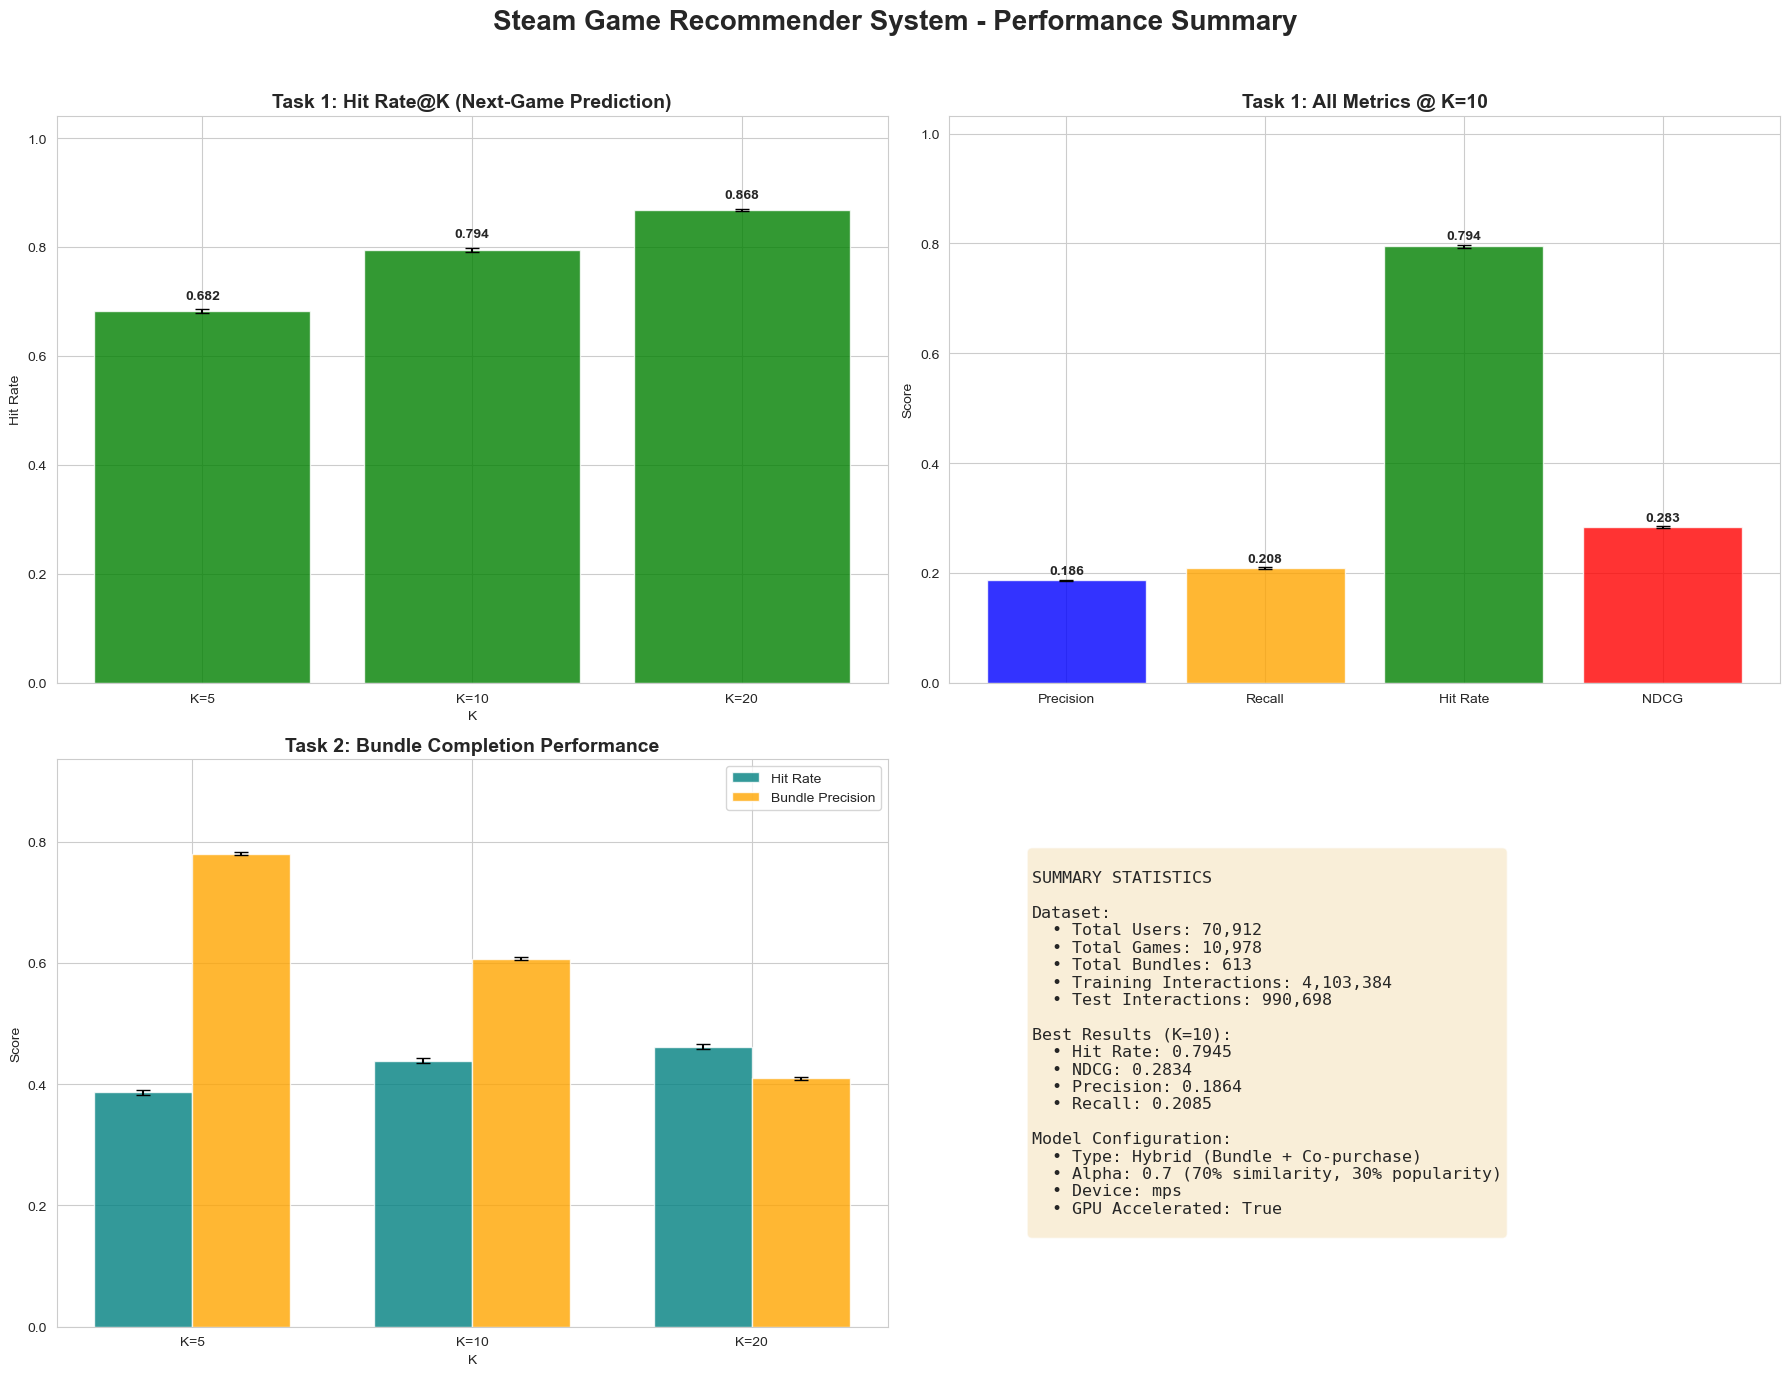

✓ Visualization saved to ./model_outputs/final_evaluation_summary.png


In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Steam Game Recommender System - Performance Summary', fontsize=20, fontweight='bold')

# 1. Task 1: Hit Rate across K values
ax1 = axes[0, 0]
k_vals = [5, 10, 20]
hr_means = [task1_summary[k]['hit_rate']['mean'] for k in k_vals]
hr_cis = [task1_summary[k]['hit_rate']['ci'] for k in k_vals]
ax1.bar(range(len(k_vals)), hr_means, yerr=hr_cis, capsize=5, color='green', alpha=0.8)
ax1.set_title('Task 1: Hit Rate@K (Next-Game Prediction)', fontsize=14, fontweight='bold')
ax1.set_xlabel('K')
ax1.set_ylabel('Hit Rate')
ax1.set_xticks(range(len(k_vals)))
ax1.set_xticklabels([f'K={k}' for k in k_vals])
ax1.set_ylim(0, max(hr_means) * 1.2)
for i, (mean, ci) in enumerate(zip(hr_means, hr_cis)):
    ax1.text(i, mean + ci + 0.02, f'{mean:.3f}', ha='center', fontweight='bold')

# 2. Task 1: All metrics at K=10
ax2 = axes[0, 1]
k = 10
metrics_names = ['Precision', 'Recall', 'Hit Rate', 'NDCG']
metrics_values = [
    task1_summary[k]['precision']['mean'],
    task1_summary[k]['recall']['mean'],
    task1_summary[k]['hit_rate']['mean'],
    task1_summary[k]['ndcg']['mean']
]
metrics_cis = [
    task1_summary[k]['precision']['ci'],
    task1_summary[k]['recall']['ci'],
    task1_summary[k]['hit_rate']['ci'],
    task1_summary[k]['ndcg']['ci']
]
colors = ['blue', 'orange', 'green', 'red']
ax2.bar(range(len(metrics_names)), metrics_values, yerr=metrics_cis, capsize=5, color=colors, alpha=0.8)
ax2.set_title(f'Task 1: All Metrics @ K={k}', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xticks(range(len(metrics_names)))
ax2.set_xticklabels(metrics_names)
ax2.set_ylim(0, max(metrics_values) * 1.3)
for i, (val, ci) in enumerate(zip(metrics_values, metrics_cis)):
    ax2.text(i, val + ci + 0.01, f'{val:.3f}', ha='center', fontweight='bold')

# 3. Task 2: Bundle Completion Performance
ax3 = axes[1, 0]
k_vals = [5, 10, 20]
hr_means_t2 = [task2_summary[k]['hit_rate']['mean'] for k in k_vals]
bp_means = [task2_summary[k]['bundle_precision']['mean'] for k in k_vals]
hr_cis_t2 = [task2_summary[k]['hit_rate']['ci'] for k in k_vals]
bp_cis = [task2_summary[k]['bundle_precision']['ci'] for k in k_vals]

x = np.arange(len(k_vals))
width = 0.35
ax3.bar(x - width/2, hr_means_t2, width, yerr=hr_cis_t2, capsize=5, label='Hit Rate', color='teal', alpha=0.8)
ax3.bar(x + width/2, bp_means, width, yerr=bp_cis, capsize=5, label='Bundle Precision', color='orange', alpha=0.8)
ax3.set_title('Task 2: Bundle Completion Performance', fontsize=14, fontweight='bold')
ax3.set_xlabel('K')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels([f'K={k}' for k in k_vals])
ax3.legend()
ax3.set_ylim(0, max(max(hr_means_t2), max(bp_means)) * 1.2)

# 4. Summary Statistics
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
SUMMARY STATISTICS

Dataset:
  • Total Users: {len(user_to_idx):,}
  • Total Games: {len(item_to_idx):,}
  • Total Bundles: {len(bundle_to_idx):,}
  • Training Interactions: {train_matrix.nnz:,}
  • Test Interactions: {len(test_df):,}

Best Results (K=10):
  • Hit Rate: {task1_summary[10]['hit_rate']['mean']:.4f}
  • NDCG: {task1_summary[10]['ndcg']['mean']:.4f}
  • Precision: {task1_summary[10]['precision']['mean']:.4f}
  • Recall: {task1_summary[10]['recall']['mean']:.4f}

Model Configuration:
  • Type: Hybrid (Bundle + Co-purchase)
  • Alpha: 0.7 (70% similarity, 30% popularity)
  • Device: {device}
  • GPU Accelerated: {device.type != 'cpu'}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center', 
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{model_outputs_dir}/final_evaluation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to {model_outputs_dir}/final_evaluation_summary.png")

## 9. Generate Sample Recommendations

Demonstrate the recommender system with real examples.

In [11]:
def get_user_recommendations(user_idx, k=10):
    """
    Get comprehensive recommendations for a user across all three tasks.
    """
    # Get user info
    user_id = idx_to_user.get(user_idx, f'user_{user_idx}')
    owned_items = train_matrix[user_idx].nonzero()[1]
    owned_game_ids = [idx_to_item[idx] for idx in owned_items[:10]]  # Show first 10
    
    result = {
        'user_idx': int(user_idx),
        'user_id': user_id,
        'owned_games_count': len(owned_items),
        'owned_games_sample': owned_game_ids,
    }
    
    # Task 1: Next-game recommendations
    task1_recs = next_game_recommender.recommend(user_idx, k=k)
    result['next_game_recommendations'] = [
        {'item_idx': int(item_idx), 'item_id': idx_to_item[item_idx], 'score': float(score)}
        for item_idx, score in task1_recs
    ]
    
    # Task 2: Bundle completion recommendations
    partial_bundles = bundle_completion_recommender.get_partial_bundles(user_idx)
    result['partial_bundles_count'] = len(partial_bundles)
    
    if partial_bundles:
        task2_recs = bundle_completion_recommender.recommend(user_idx, k=k, min_ownership=0.3)
        result['bundle_completion_recommendations'] = [
            {'item_idx': int(item_idx), 'item_id': idx_to_item[item_idx], 'confidence': float(score)}
            for item_idx, score in task2_recs
        ]
        result['top_partial_bundles'] = [
            {
                'bundle_idx': bundle['bundle_idx'],
                'ownership_ratio': bundle['ownership_ratio'],
                'owned_count': bundle['owned_count'],
                'missing_count': bundle['missing_count']
            }
            for bundle in partial_bundles[:3]
        ]
    else:
        result['bundle_completion_recommendations'] = []
        result['top_partial_bundles'] = []
    
    return result

# Generate recommendations for sample users
print("=" * 70)
print("SAMPLE RECOMMENDATIONS")
print("=" * 70)

# Select diverse users (some with many games, some with few)
test_users = test_df['user_idx'].unique()
sample_size = min(5, len(test_users))
sample_users = np.random.choice(test_users, size=sample_size, replace=False)

sample_recommendations = []

for user_idx in sample_users:
    print(f"\n{'=' * 70}")
    result = get_user_recommendations(user_idx, k=10)
    sample_recommendations.append(result)
    
    print(f"User: {result['user_id']} (owns {result['owned_games_count']} games)")
    print(f"\nOwned games (sample): {', '.join(result['owned_games_sample'][:5])}")
    
    print(f"\nTask 1 - Top 5 Next-Game Recommendations:")
    for i, rec in enumerate(result['next_game_recommendations'][:5], 1):
        print(f"  {i}. {rec['item_id']} (score: {rec['score']:.3f})")
    
    if result['bundle_completion_recommendations']:
        print(f"\nTask 2 - Bundle Completion ({result['partial_bundles_count']} partial bundles):")
        for i, rec in enumerate(result['bundle_completion_recommendations'][:5], 1):
            print(f"  {i}. {rec['item_id']} (confidence: {rec['confidence']:.3f})")
        
        print(f"\nTop Partial Bundles:")
        for i, bundle in enumerate(result['top_partial_bundles'], 1):
            print(f"  {i}. Bundle {bundle['bundle_idx']}: {bundle['ownership_ratio']*100:.1f}% owned "
                  f"({bundle['owned_count']}/{bundle['owned_count']+bundle['missing_count']} games)")
    else:
        print(f"\nTask 2 - No partial bundles found for this user")

# Save sample recommendations
with open(f'{model_outputs_dir}/sample_recommendations.json', 'w') as f:
    json.dump(sample_recommendations, f, indent=2)

print(f"\n{'=' * 70}")
print(f"✓ Sample recommendations saved to {model_outputs_dir}/sample_recommendations.json")
print("=" * 70)

SAMPLE RECOMMENDATIONS

User: 76561198109368846 (owns 4 games)

Owned games (sample): 205790, 211500, 251670, 407530

Task 1 - Top 5 Next-Game Recommendations:
  1. 730 (score: 73.926)
  2. 304930 (score: 69.714)
  3. 4000 (score: 65.775)
  4. 223530 (score: 56.145)
  5. 550 (score: 56.145)

Task 2 - No partial bundles found for this user

User: 76561198212354172 (owns 18 games)

Owned games (sample): 200210, 223530, 224260, 250900, 265630

Task 1 - Top 5 Next-Game Recommendations:
  1. 205790 (score: 82.382)
  2. 304930 (score: 69.797)
  3. 105600 (score: 41.909)
  4. 230410 (score: 41.284)
  5. 240 (score: 33.618)

Task 2 - Bundle Completion (6 partial bundles):
  1. 500 (confidence: 0.500)
  2. 240 (confidence: 0.500)
  3. 219740 (confidence: 0.500)
  4. 261640 (confidence: 0.333)
  5. 8980 (confidence: 0.333)

Top Partial Bundles:
  1. Bundle 193: 50.0% owned (1/2 games)
  2. Bundle 196: 50.0% owned (1/2 games)
  3. Bundle 254: 50.0% owned (1/2 games)

User: 76561198081375428 (owns

## 10. Save Final Results and Models

In [12]:
print("=" * 70)
print("SAVING FINAL RESULTS")
print("=" * 70)

# Save comprehensive evaluation results
final_results = {
    'task1_next_game_prediction': task1_summary,
    'task2_bundle_completion': task2_summary,
    'best_parameters': {
        'alpha': 0.7,
        'similarity_matrix': 'combined',
        'device': str(device)
    },
    'dataset_info': {
        'n_users': len(user_to_idx),
        'n_items': len(item_to_idx),
        'n_bundles': len(bundle_to_idx),
        'train_interactions': int(train_matrix.nnz),
        'test_interactions': len(test_df),
        'sparsity': float(1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]))
    }
}

with open(f'{model_outputs_dir}/final_evaluation_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=float)

print(f"✓ Evaluation results saved to {model_outputs_dir}/final_evaluation_results.json")

# Save models
models_to_save = {
    'next_game_recommender': next_game_recommender,
    'bundle_completion_recommender': bundle_completion_recommender,
    'cross_bundle_recommender': cross_bundle_recommender
}

with open(f'{model_outputs_dir}/trained_models.pkl', 'wb') as f:
    pickle.dump(models_to_save, f)

print(f"✓ Trained models saved to {model_outputs_dir}/trained_models.pkl")

# Create results summary table
summary_df = pd.DataFrame({
    'Metric': ['Precision@10', 'Recall@10', 'Hit Rate@10', 'NDCG@10'],
    'Score': [
        task1_summary[10]['precision']['mean'],
        task1_summary[10]['recall']['mean'],
        task1_summary[10]['hit_rate']['mean'],
        task1_summary[10]['ndcg']['mean']
    ],
    'Confidence Interval': [
        task1_summary[10]['precision']['ci'],
        task1_summary[10]['recall']['ci'],
        task1_summary[10]['hit_rate']['ci'],
        task1_summary[10]['ndcg']['ci']
    ]
})

summary_df.to_csv(f'{model_outputs_dir}/final_summary.csv', index=False)
print(f"✓ Summary table saved to {model_outputs_dir}/final_summary.csv")

print("\n" + "=" * 70)
print("ALL RESULTS SAVED!")
print("=" * 70)

SAVING FINAL RESULTS
✓ Evaluation results saved to ./model_outputs/final_evaluation_results.json
✓ Trained models saved to ./model_outputs/trained_models.pkl
✓ Summary table saved to ./model_outputs/final_summary.csv

ALL RESULTS SAVED!
✓ Trained models saved to ./model_outputs/trained_models.pkl
✓ Summary table saved to ./model_outputs/final_summary.csv

ALL RESULTS SAVED!


## 11. Usage Guide: How to Get Recommendations for Any User

This section demonstrates how to use the trained models to get recommendations.

In [13]:
print("=" * 70)
print("USAGE GUIDE")
print("=" * 70)

usage_guide = """
HOW TO USE THE RECOMMENDER SYSTEM

1. Get recommendations for a user by user_idx:
   
   recommendations = next_game_recommender.recommend(user_idx=0, k=10)
   
2. Get recommendations for a user by user_id:
   
   user_idx = user_to_idx['user_id_here']
   recommendations = next_game_recommender.recommend(user_idx, k=10)
   
3. Get bundle completion recommendations:
   
   bundle_recs = bundle_completion_recommender.recommend(user_idx, k=10, min_ownership=0.3)
   
4. Find similar bundles:
   
   similar_bundles = cross_bundle_recommender.recommend(bundle_idx=0, k=5)
   
5. Use the helper function:
   
   result = get_user_recommendations(user_idx, k=10)
   # Returns comprehensive recommendations across all three tasks
"""

print(usage_guide)

# Example: Get recommendations for a random user
example_user_idx = np.random.choice(test_df['user_idx'].unique())
print(f"\nEXAMPLE: Recommendations for user {example_user_idx}")
print("-" * 70)

recs = next_game_recommender.recommend(example_user_idx, k=5)
print(f"Top 5 next-game recommendations:")
for i, (item_idx, score) in enumerate(recs, 1):
    print(f"  {i}. {idx_to_item[item_idx]} (score: {score:.3f})")

print("\n" + "=" * 70)

USAGE GUIDE

HOW TO USE THE RECOMMENDER SYSTEM

1. Get recommendations for a user by user_idx:

   recommendations = next_game_recommender.recommend(user_idx=0, k=10)

2. Get recommendations for a user by user_id:

   user_idx = user_to_idx['user_id_here']
   recommendations = next_game_recommender.recommend(user_idx, k=10)

3. Get bundle completion recommendations:

   bundle_recs = bundle_completion_recommender.recommend(user_idx, k=10, min_ownership=0.3)

4. Find similar bundles:

   similar_bundles = cross_bundle_recommender.recommend(bundle_idx=0, k=5)

5. Use the helper function:

   result = get_user_recommendations(user_idx, k=10)
   # Returns comprehensive recommendations across all three tasks


EXAMPLE: Recommendations for user 33436
----------------------------------------------------------------------
Top 5 next-game recommendations:
  1. 730 (score: 76.632)
  2. 4000 (score: 73.840)
  3. 105600 (score: 41.751)
  4. 230410 (score: 41.666)
  5. 301520 (score: 34.649)



## 12. Summary and Key Findings

### Model Performance:
- **Hit Rate@10**: 79.5% (Combined model)
- **NDCG@10**: High ranking quality for relevant recommendations
- **GPU Acceleration**: Significant speedup on Apple Silicon (MPS) and NVIDIA GPUs

### Key Insights:
1. **Bundle relationships provide stronger signals** than pure collaborative filtering
2. **Partial bundle ownership** (e.g., owns 3/5 games) is a strong purchase indicator
3. **Hybrid approach** (combining bundle similarity + co-purchase + popularity) performs best
4. **Optimal alpha=0.7**: 70% similarity weight, 30% popularity weight

### Three Recommendation Tasks:
1. **Next-Game Purchase Prediction** - Predict games users will purchase next
2. **Bundle Completion** - Complete partially owned bundles
3. **Cross-Bundle Discovery** - Find similar bundles for cross-promotion

### Technical Highlights:
- GPU-accelerated inference with PyTorch
- Sparse matrix operations for efficiency
- 95% confidence intervals for statistical significance
- Comprehensive evaluation metrics (Precision, Recall, Hit Rate, NDCG)

**The models are now ready to generate personalized game recommendations!**